# Predicting the Hidden Gem Score of a Netflix movie or series

In [1]:
# Core librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Machine learning librairies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

In [2]:
netflix = pd.read_csv("netflix-rotten-tomatoes-metacritic-imdb.csv")

In [3]:
# Converting the csv to a dataframe for further analysis
netflix = pd.DataFrame(netflix)
netflix

,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,Writer,...,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,...,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,NaN,NaN
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,...,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,6.4,Canada,1-2 hour,Brendan Walsh,"Brendan Walsh, Daley Nixon",...,2021-03-04,NaN,https://www.netflix.com/watch/81305978,https://www.imdb.com/title/tt8945942,"Trapped in a frozen car during a blizzard, a p...",1720.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BODM2MD...,https://www.youtube.com/watch?v=0RvV7TNUlkQ,YouTube
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,"Belgium,Netherlands",< 30 minutes,NaN,NaN,...,2021-03-04,NaN,https://www.netflix.com/watch/81336456,https://www.imdb.com/title/tt6132758,"Upon moving into a new place, a 20-something r...",1147.0,https://occ-0-1489-1490.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BNWRkMz...,NaN,NaN
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",1-2 hour,Stephen Irwin,NaN,...,2021-03-04,NaN,https://www.netflix.com/watch/81078393,https://www.imdb.com/title/tt2023611,Inspired by her moms rebellious past and a con...,63.0,https://occ-0-4039-1500.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BODYyNW...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15475,K-POP Extreme Survival,NaN,"TV Dramas,TV Programmes,TV Comedies,Romantic T...",NaN,Series,NaN,"South Korea,Argentina,United Kingdom,Australia...",< 30 minutes,NaN,NaN,...,2015-04-14,NaN,https://www.netflix.com/watch/80031595,NaN,Seung Yeon decides to chase her dream of becom...,NaN,https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,NaN,NaN,NaN
15476,DreamWorks Shreks Swamp Stories,NaN,"Animal Tales,Family Comedies,Family Adventures...",NaN,Series,NaN,"Russia,Hong Kong,Hungary,Australia,South Korea...",< 30 minutes,NaN,NaN,...,2015-04-14,NaN,https://www.netflix.com/watch/70242630,NaN,"Shrek celebrates Halloween, Puss in Boots is c...",NaN,https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,NaN,NaN,NaN
15477,DreamWorks Happy Holidays from Madagascar,"Animation, Comedy, Family","TV Comedies,Kids TV,Animal Tales,TV Cartoons,T...",English,Series,8.4,"Belgium,Switzerland,United States,Germany,Unit...",< 30 minutes,NaN,NaN,...,2015-04-14,NaN,https://www.netflix.com/watch/70259784,NaN,Madagascar goes wild with holiday spirit in th...,71.0,https://occ-0-2773-2774.1.nflxso.net/dnm/api/v...,NaN,NaN,NaN
15478,DreamWorks Holiday Classics,"Animation, Comedy, Family","TV Comedies,Kids TV,TV Cartoons,TV Programmes,...",English,Series,8.2,"Belgium,Switzerland,Germany,Argentina,United K...",< 30 minutes,NaN,NaN,...,2015-04-14,Fox,https://www.netflix.com/watch/70221348,NaN,Join your DreamWorks friends for these four ho...,82.0,https://occ-0-2851-38.1.nflxso

## Cleaning data and selecting features

In [4]:
# Choosing features likely to affect the score of a movie
netflix = netflix[['Genre','Tags','Languages','Series or Movie','Hidden Gem Score',
                   'Runtime','Netflix Release Date']]
netflix.head()

,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Runtime,Netflix Release Date
0,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,< 30 minutes,2021-03-04
1,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,1-2 hour,2021-03-04
2,"Drama, Thriller",Thrillers,English,Movie,6.4,1-2 hour,2021-03-04
3,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,< 30 minutes,2021-03-04
4,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,1-2 hour,2021-03-04


In [5]:
# Checking for columns with null values
netflix.isnull().mean()

Genre                   0.110465
Tags                    0.004328
Languages               0.126227
Series or Movie         0.000000
Hidden Gem Score        0.135724
Runtime                 0.000065
Netflix Release Date    0.000000
dtype: float64

In [6]:
# Deleting the rows that contain null values
netflix = netflix.dropna(ignore_index=True)
netflix.isnull().mean()

Genre                   0.0
Tags                    0.0
Languages               0.0
Series or Movie         0.0
Hidden Gem Score        0.0
Runtime                 0.0
Netflix Release Date    0.0
dtype: float64

## Understanding the data

In [7]:
netflix.dtypes


Genre                    object
Tags                     object
Languages                object
Series or Movie          object
Hidden Gem Score        float64
Runtime                  object
Netflix Release Date     object
dtype: object

In [8]:
netflix.shape

(13031, 7)

In [9]:
netflix.head()

,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Runtime,Netflix Release Date
0,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,< 30 minutes,2021-03-04
1,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,1-2 hour,2021-03-04
2,"Drama, Thriller",Thrillers,English,Movie,6.4,1-2 hour,2021-03-04
3,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,7.7,< 30 minutes,2021-03-04
4,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,8.1,1-2 hour,2021-03-04


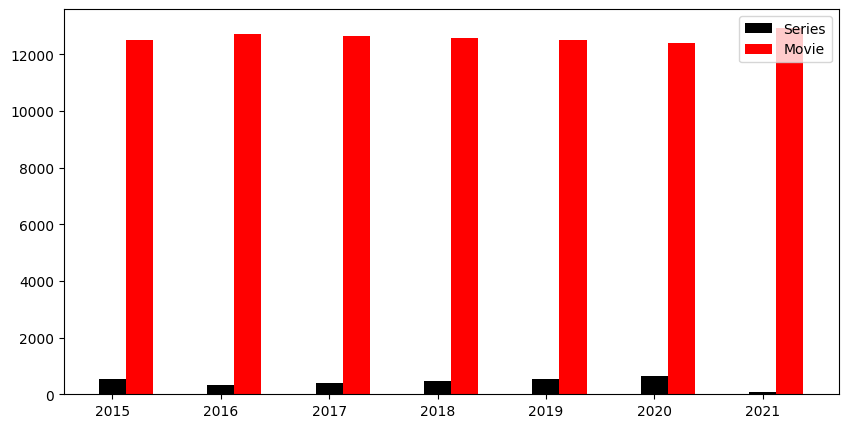

In [10]:
# Showing which type of show was released over time
year = (pd.to_datetime(netflix['Netflix Release Date']).dt.year).unique()
series = []
movie = []
for i in range(len(year)):
    totalS = 0
    totalM = 0
    for j in range(len(netflix['Series or Movie'])):
        if (netflix['Series or Movie'][j]=='Series') and (pd.to_datetime(netflix['Netflix Release Date'][j]).year==year[i]):
            totalS+=1
        else:
            totalM+=1
    series.append(totalS)
    movie.append(totalM)
     
yearm = [y+0.25 for y in year]
plt.subplots(figsize=(10,5))
plt.bar(year, series, color='black', width=0.25)
plt.bar(yearm, movie, color='red', width=0.25)
plt.legend(['Series','Movie'])

<Axes: >

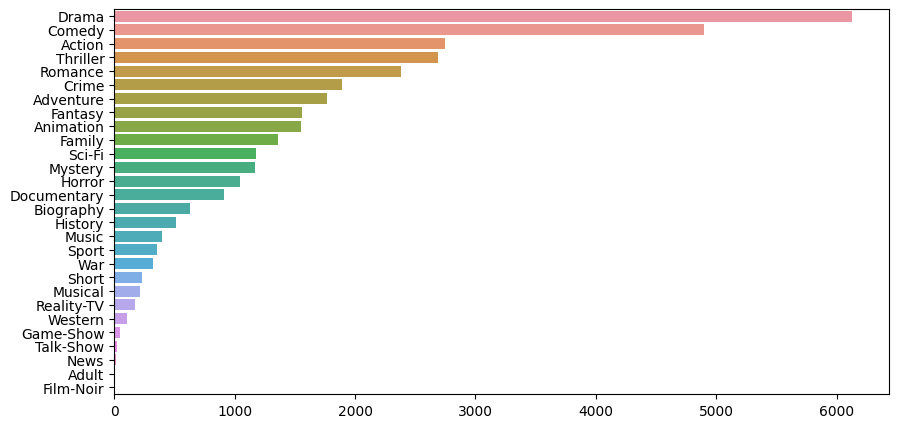

In [11]:
# Showing the most viewed genres over time
genres_count = Counter(', '.join(netflix['Genre']).split(', '))
genres_dict = dict(genres_count)

values = list(genres_count.values())
keys = list(genres_dict.keys())

sorted_indices = np.argsort(values)[::-1]
genres = {keys[i]:values[i] for i in sorted_indices}

df = pd.DataFrame(genres,index=[0])
plt.subplots(figsize=(10,5))
sns.barplot(data=df, orient='h')

## Feature Engineering

In [12]:
netflix.dtypes

Genre                    object
Tags                     object
Languages                object
Series or Movie          object
Hidden Gem Score        float64
Runtime                  object
Netflix Release Date     object
dtype: object

In [13]:
# Creating dummies for Genre to have each genre as a column
Genres = np.unique(', '.join(netflix['Genre']).split(', '))
for Genre in Genres:
    netflix[Genre] = netflix['Genre'].str.contains(Genre).astype(int)

netflix.drop('Genre',axis=1,inplace=True)

In [14]:
# Creating dummies for Tags to have each tag as a column
dummies = netflix['Tags'].str.get_dummies(sep=',')
netflix = pd.concat([netflix.drop(columns='Tags'), dummies], axis=1)

In [15]:
# Creating dummies for Languages to have each language as a column
dummies = netflix['Languages'].str.get_dummies(sep=",")
netflix = pd.concat([netflix.drop(columns='Languages'), dummies], axis=1)

In [16]:
# Creating dummies for Series or Movies
netflix = netflix.join(pd.get_dummies(netflix['Series or Movie']).astype(int)).drop('Series or Movie',axis=1)

In [17]:
# Creating dummies for Runtime
netflix = netflix.join(pd.get_dummies(netflix['Runtime']).astype(int)).drop('Runtime',axis=1)

In [18]:
# Splitting datetime into year
netflix['Year'] = pd.to_datetime(
    netflix['Netflix Release Date'], errors='coerce'
).dt.year

netflix.drop(columns='Netflix Release Date', inplace=True)

In [19]:
# Checking if there are null columns
netflix.isnull().sum()

Hidden Gem Score    0
Action              0
Adult               0
Adventure           0
Animation           0
                   ..
1-2 hour            0
30-60 mins          0
< 30 minutes        0
> 2 hrs             0
Year                0
Length: 1311, dtype: int64

## Building the model

In [20]:
# Splitting the input and output features
X = netflix.drop('Hidden Gem Score',axis=1)
y = netflix['Hidden Gem Score']

In [21]:
X = X.rename(str,axis="columns") 

In [23]:
# Splitting the training and test data in 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [24]:
# Fitting the Support Vector Regressor
model_sv = SVR()
model_sv.fit(X_train, y_train)

SVR()

In [25]:
# Fitting the Random Forest Regressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [26]:
# Fitting the Decision Tree Regressor
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [27]:
sv_pred = model_sv.predict(X_test)

In [28]:
rf_pred = model_rf.predict(X_test)

In [29]:
dt_pred = model_dt.predict(X_test)

In [30]:
# Mean absolute error is used to calculate the error between the ground truth value and predicted value.
print("Support Vector Regressor:",mean_squared_error(y_test,sv_pred))
print("Random Forest Regressor:", mean_squared_error(y_test,rf_pred))
print("Decision Tree Regressor:", mean_squared_error(y_test, dt_pred))

Support Vector Regressor: 5.62244926979061
Random Forest Regressor: 1.9075317759353667
Decision Tree Regressor: 3.2461654099716304


## Choosing the best model

In [31]:
# The model which presented the least amount of errors was the RandomForestRegressor
model = model_rf

## Inspecting the model

In [32]:
# Showing the most influential features
importance = model.feature_importances_
feature = pd.DataFrame(importance, index=X_train.columns, columns=['Importance']).sort_values('Importance',ascending=False)
feature

,Importance
English,0.222253
Year,0.090504
Documentary,0.073146
< 30 minutes,0.047315
Thriller,0.032359
...,...
Breton,0.000000
British Sign Language,0.000000
Hausa,0.000000
Cheyenne,0.000000


### Plotting a graph to show the importance of the features in determining the Hidden Gem Score

<Axes: xlabel='Importance'>

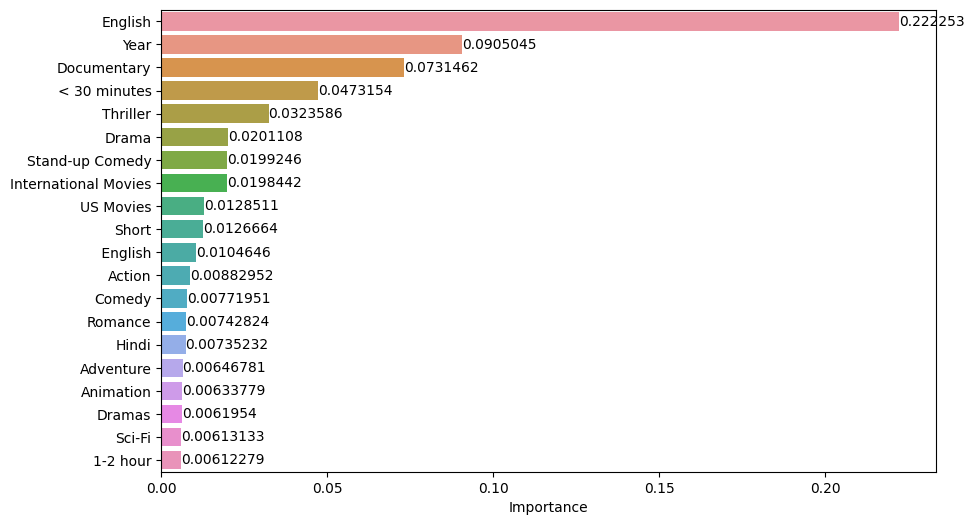

In [34]:
plt.subplots(figsize=(10,6))
ax = sns.barplot(y=feature.index[:20], x=feature.Importance[:20])
ax.bar_label(ax.containers[0], fontsize=10)
ax